In [1]:
#######imports and data read#######
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from pre_processing import *
from algorithms import *
from spectrum_gen import *
from data_gen import *
from analysis import *
from datasets import *
from evaluation import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
gene_list_for_plot = ['CDC20','CDK1','RRM2','PCNA']
#adata = sc.read_csv('hela/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt', delimiter='\t').T
adata = sc.read_csv('hela/GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt', delimiter='\t').T
adata = shuffle_adata(adata)
adata


View of AnnData object with n_obs × n_vars = 1029 × 25797

In [2]:
#######data cleaning#######
#sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=0)
i=1
while adata.obs['n_genes'].mean() <4500: #remove cells until we reach mean counts of 4,500 as suggested by https://www.embopress.org/doi/full/10.15252/msb.20209946
    sc.pp.filter_cells(adata, min_genes=i)
    i+=5
#sc.pp.filter_cells(adata, min_counts=3000) #4000
adata_for_inference = adata.copy()
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 683 × 25797
    obs: 'n_genes'

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


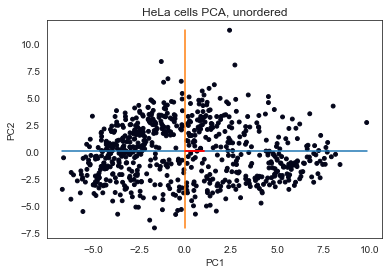

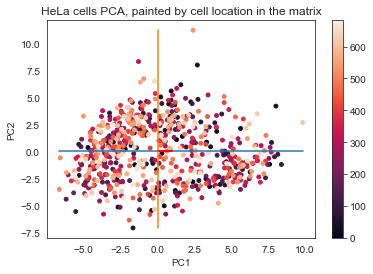

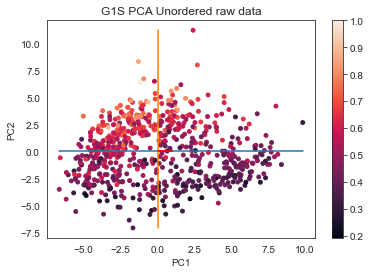

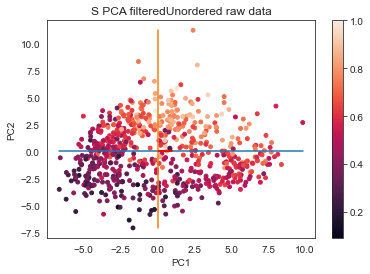

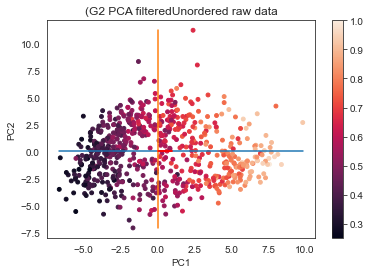

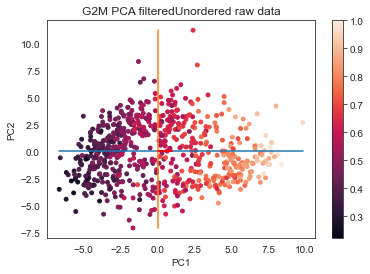

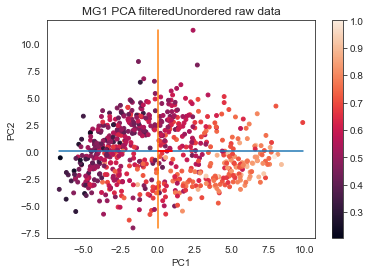

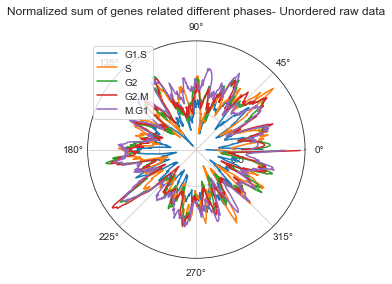

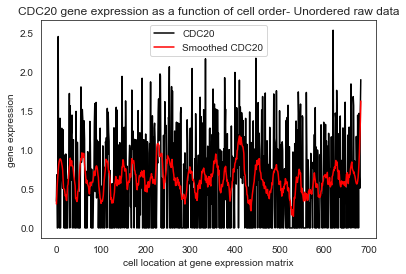

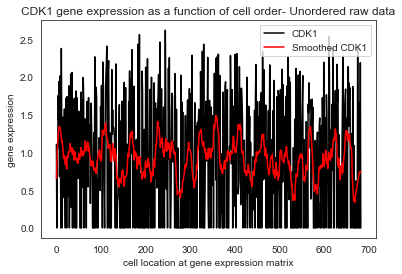

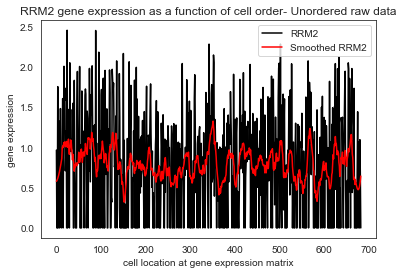

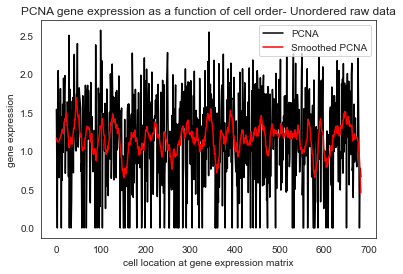

Mean AUC-ROC: 0.27448700000000004


In [3]:
#######data cleaning#######
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
bdata = copy.deepcopy(adata.copy())
sc.pp.filter_genes_dispersion(adata,n_top_genes=7000)
ranged_pca_2d(adata.X,color=np.zeros(adata.X.shape[0]),title=("HeLa cells PCA, unordered"),dis_colorbar=True)
all_plots_hela(adata,title="Unordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='r', title="Unordered raw data")
#######Gene inference over un-ordered data- the result expected to be low#######
auc_unordered= np.zeros(100)
for i in range(100):
    auc_unordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_unordered)))

Iteration number: 0 function value= 1.1971042010570045e-22
Iteration number: 25 function value= 536.6405088156662
Iteration number: 50 function value= 566.2700219459427
Iteration number: 75 function value= 572.0258864660636
Iteration number: 100 function value= 575.7786532676771
Iteration number: 125 function value= 581.5090715333129
Iteration number: 150 function value= 580.1784330045423
Iteration number: 175 function value= 585.5475129472766
Iteration number: 200 function value= 586.6408982697385
Iteration number: 225 function value= 585.5782192703616


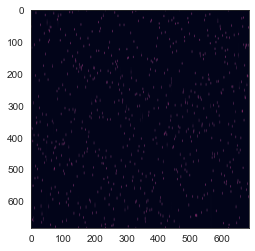

In [4]:
E_sga  , E_rec_sga = reconstruction_cyclic(adata.X , iterNum=250 , batch_size=6000)
plt.imshow(E_sga)
plt.show()

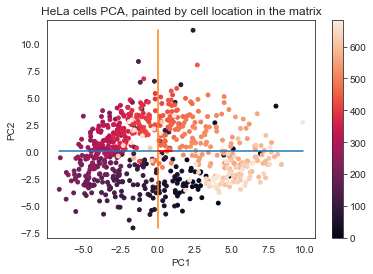

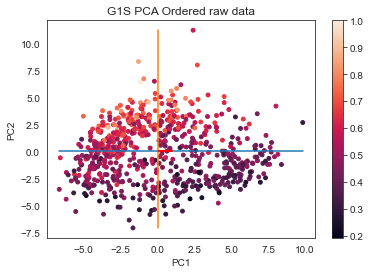

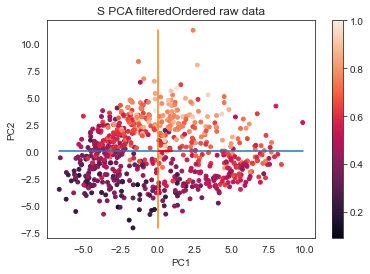

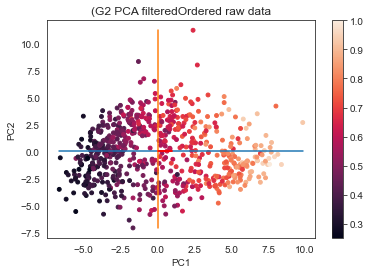

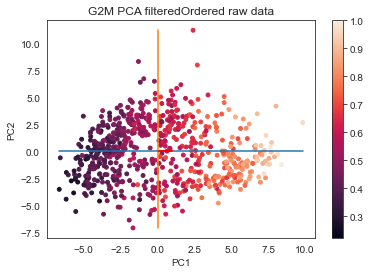

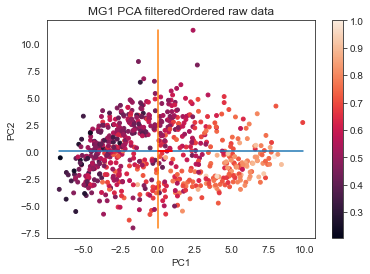

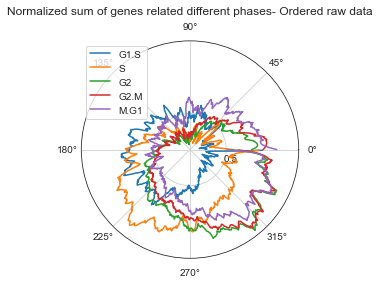

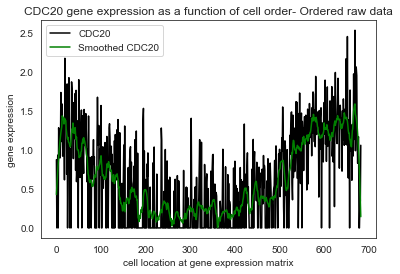

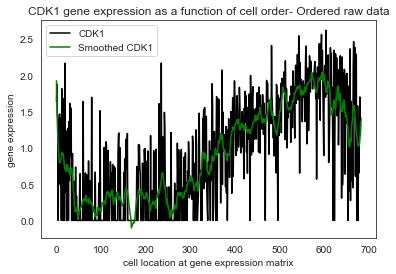

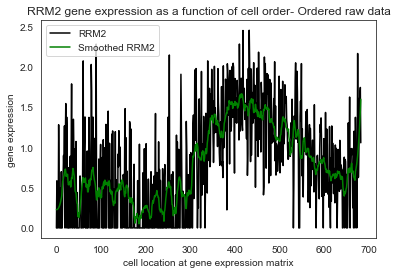

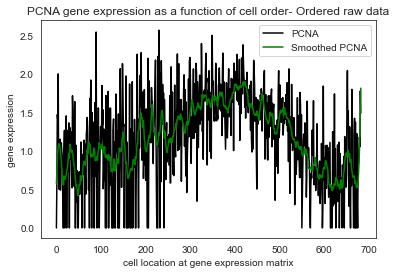

Mean AUC-ROC: 0.7989914999999997


In [5]:
#######Signal reconstruction######
sga_range= e_to_range(E_rec_sga)
adata = adata[sga_range,:]
orig_adata = copy.deepcopy(adata.copy())
all_plots_hela(adata,title="Ordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='g', title="Ordered raw data")
auc_ordered= np.zeros(100)
#######Gene inference over ordered data#######
for i in range(100):
    auc_ordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_ordered)))

Iteration number: 1 function value: 507.70148498392456
Iteration number: 26 function value: 1095.3064031838678
Iteration number: 51 function value: 2573.842129203561
Iteration number: 76 function value: 3358.5178580513393


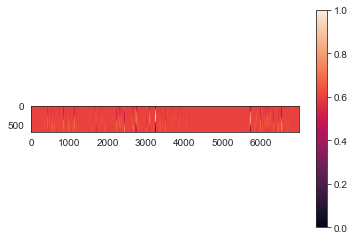

norm change 447.51697605355577


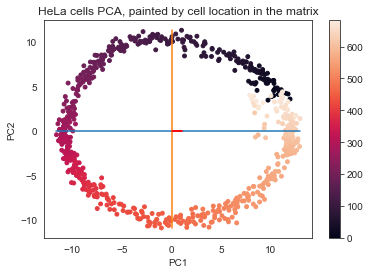

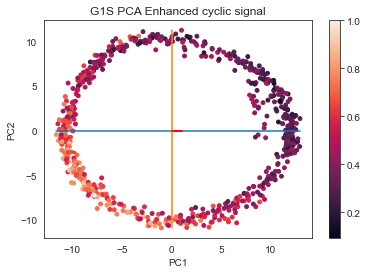

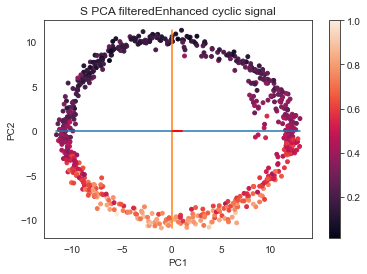

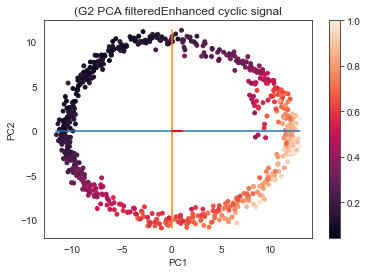

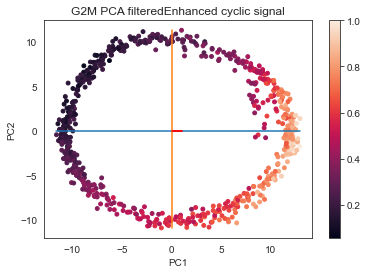

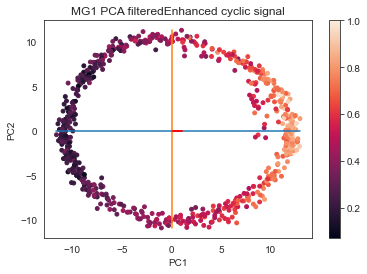

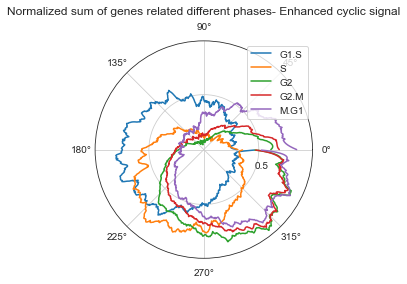

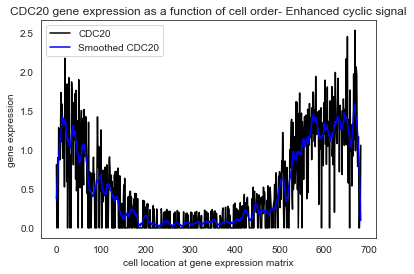

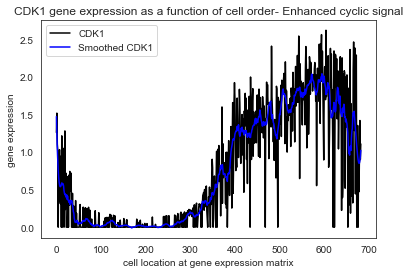

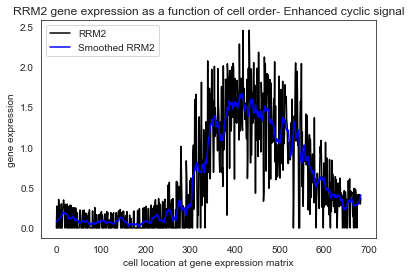

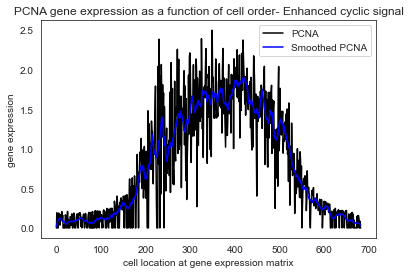

Mean AUC-ROC: 0.8316825


In [6]:
#######Signal enhancement######
adata = orig_adata.copy()
F = enhancement_cyclic(adata.X,regu=0.05,iterNum=100)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Enhanced cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='b', title="Enhanced cyclic signal")
auc_en= np.zeros(100)
for i in range(100):
    auc_en[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_en)))

starting filtering
25th Iteration    Loss :: 104.63530190806657 gradient :: 2.471410712692087
50th Iteration    Loss :: 50.47819305242602 gradient :: 1.2570501367286484
75th Iteration    Loss :: 33.5055767574502 gradient :: 0.8369705170275059
100th Iteration    Loss :: 25.44777766357445 gradient :: 0.6243529760342458
125th Iteration    Loss :: 20.788124864713915 gradient :: 0.49693067427132803
150th Iteration    Loss :: 17.76303013824429 gradient :: 0.4128371210763765
175th Iteration    Loss :: 15.635432780674627 gradient :: 0.35350365057366356
200th Iteration    Loss :: 14.051944688321683 gradient :: 0.3095661032472552
225th Iteration    Loss :: 12.82276874443297 gradient :: 0.2758132471773879
250th Iteration    Loss :: 11.837583354258463 gradient :: 0.24913967468701542
275th Iteration    Loss :: 11.026922517844472 gradient :: 0.2275371996459163
300th Iteration    Loss :: 10.346400500406283 gradient :: 0.20971536096218737
325th Iteration    Loss :: 9.7646983016589 gradient :: 0.194737

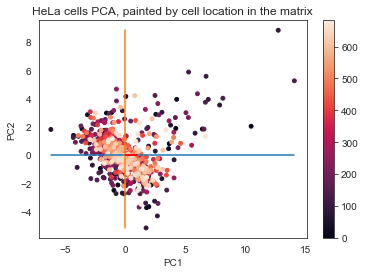

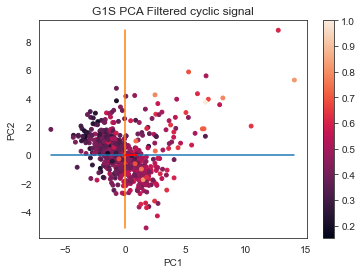

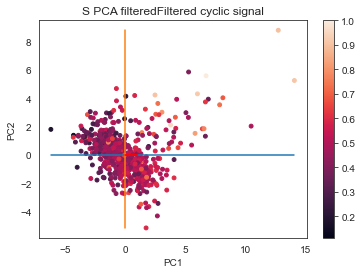

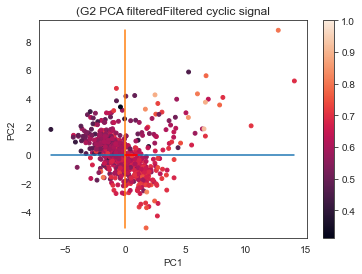

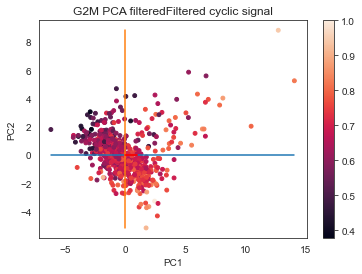

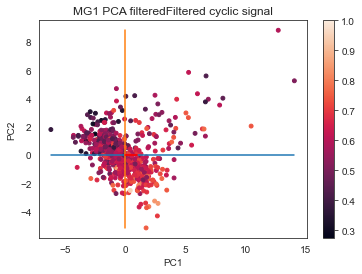

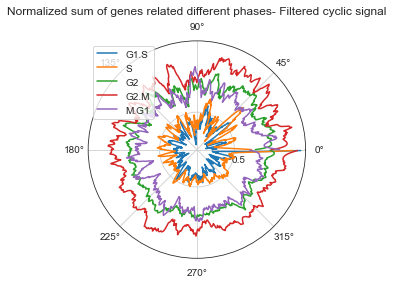

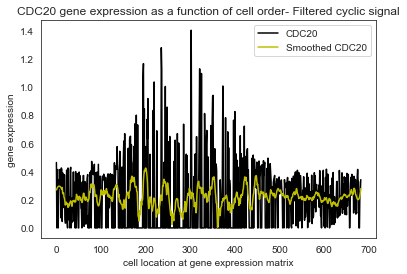

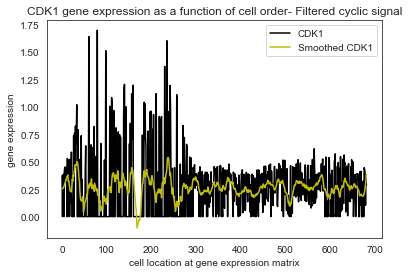

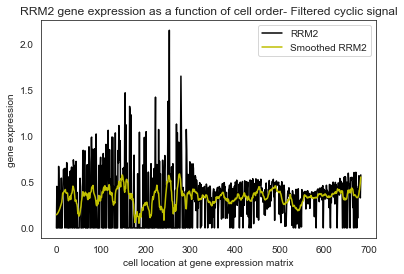

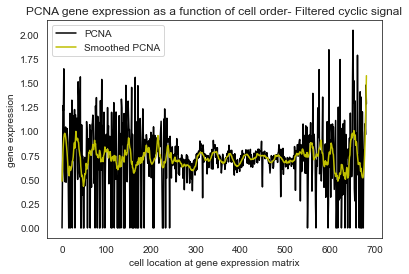

Mean AUC-ROC: 0.18485850000000006


In [7]:
#######Signal filtering######
adata = copy.deepcopy(orig_adata.copy())
F = filtering_cyclic(adata.X,regu=0,iterNum=1500)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Filtered cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='y', title="Filtered cyclic signal")
auc_filtered= np.zeros(100)
for i in range(100):
    auc_filtered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_filtered)))

starting norm: 885.04694
Iteration number: 1 function value: 507.6859567765789


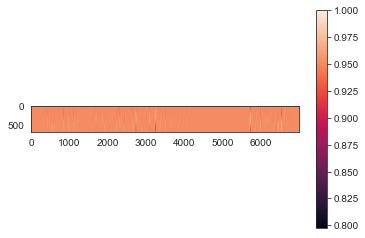

norm change 48.19282170880813


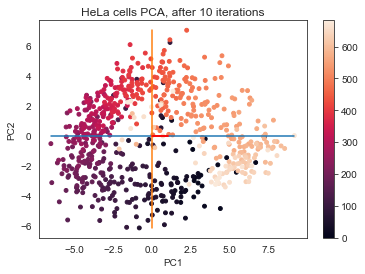

Iteration number: 1 function value: 507.6908005403402


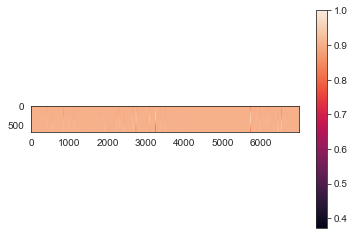

norm change 108.68084869372203


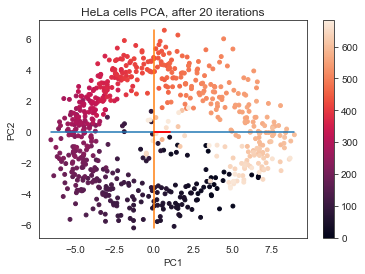

Iteration number: 1 function value: 507.6952798461415
Iteration number: 26 function value: 1094.9175835961885


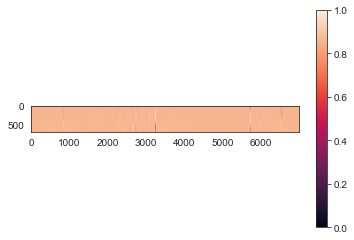

norm change 191.93590549492805


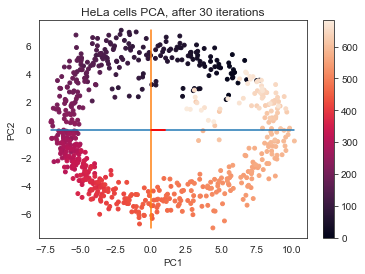

Iteration number: 1 function value: 507.6955178533608
Iteration number: 26 function value: 1096.2628733227862


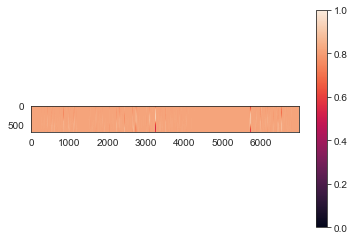

norm change 261.40187410346135


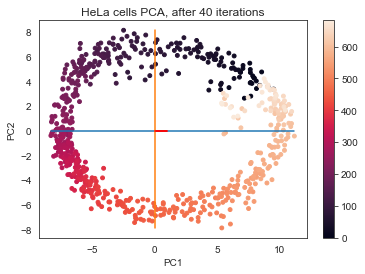

Iteration number: 1 function value: 507.67460700377535
Iteration number: 26 function value: 1094.6354011194692


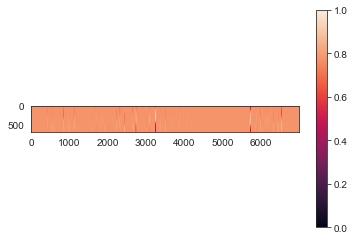

norm change 311.2721144141427


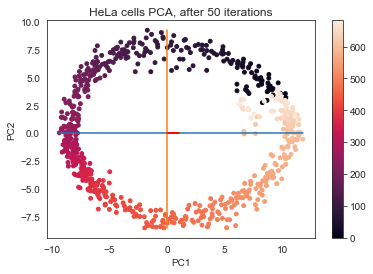

Iteration number: 1 function value: 507.70636186389663
Iteration number: 26 function value: 1095.307401390835
Iteration number: 51 function value: 2573.8873398843075


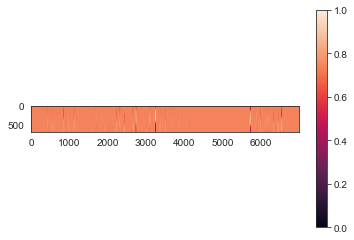

norm change 347.00490974743695


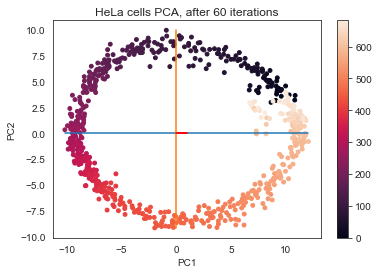

Iteration number: 1 function value: 507.68977353808896
Iteration number: 26 function value: 1094.9130656406408
Iteration number: 51 function value: 2573.645043953662


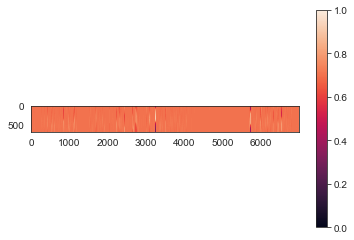

norm change 376.67594608681526


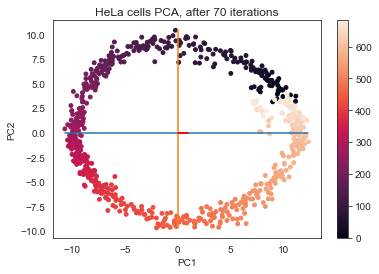

Iteration number: 1 function value: 507.6886066081836
Iteration number: 26 function value: 1095.847673371168
Iteration number: 51 function value: 2574.032993926685
Iteration number: 76 function value: 3357.2616957705563


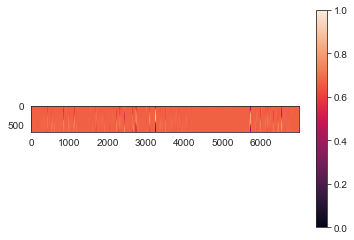

norm change 403.41072469363826


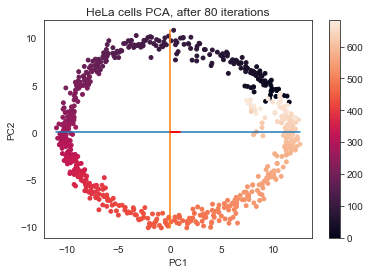

Iteration number: 1 function value: 507.68363493354394
Iteration number: 26 function value: 1095.5546421668987
Iteration number: 51 function value: 2573.583957640881
Iteration number: 76 function value: 3357.2218977318526


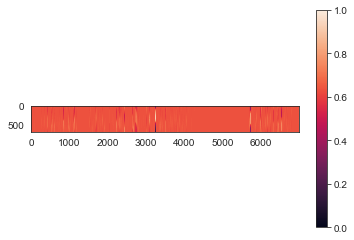

norm change 426.9514339471713


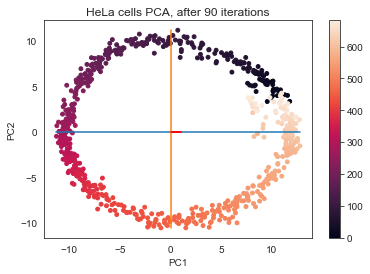

Iteration number: 1 function value: 507.6861812436033
Iteration number: 26 function value: 1095.3576511679848
Iteration number: 51 function value: 2573.918087774842
Iteration number: 76 function value: 3357.7060284941967


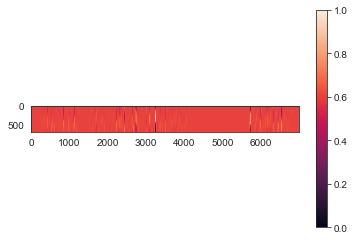

norm change 447.4654155798758


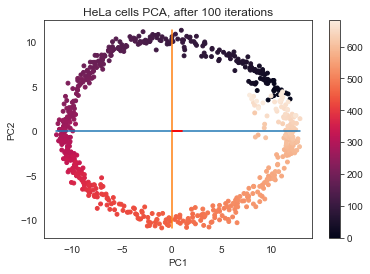

In [8]:
print("starting norm: " +str(np.linalg.norm(orig_adata.X)))
adata = copy.deepcopy(orig_adata.copy())
for i in range(10):
    adata = copy.deepcopy(orig_adata.copy())
    F = enhancement_cyclic(adata.X,regu=0.05,iterNum=(10*(i+1)))
    print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
    adata.X = adata.X * F
    ranged_pca_2d(adata.X,color=range(adata.X.shape[0]),title=("HeLa cells PCA, after "+ str((i+1)*10) +" iterations"))

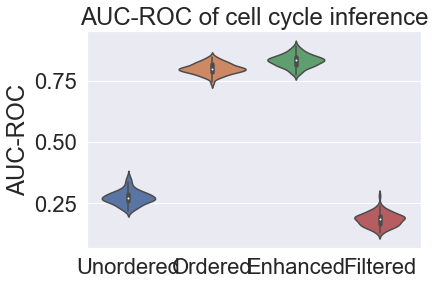

In [9]:
data = pd.DataFrame({
    "Unordered": auc_unordered,
    'Ordered': auc_ordered,
    "Enhanced": auc_en,
    "Filtered": auc_filtered,
})
sns.set_style("whitegrid")

sns.set_style("white", {"axes.facecolor": ".9"})
sns.set_style("whitegrid")

sns.set(font_scale=2)
ax = sns.violinplot(data=data)
plt.ylabel("AUC-ROC")
plt.title("AUC-ROC of cell cycle inference" ,fontsize='24')
plt.show()

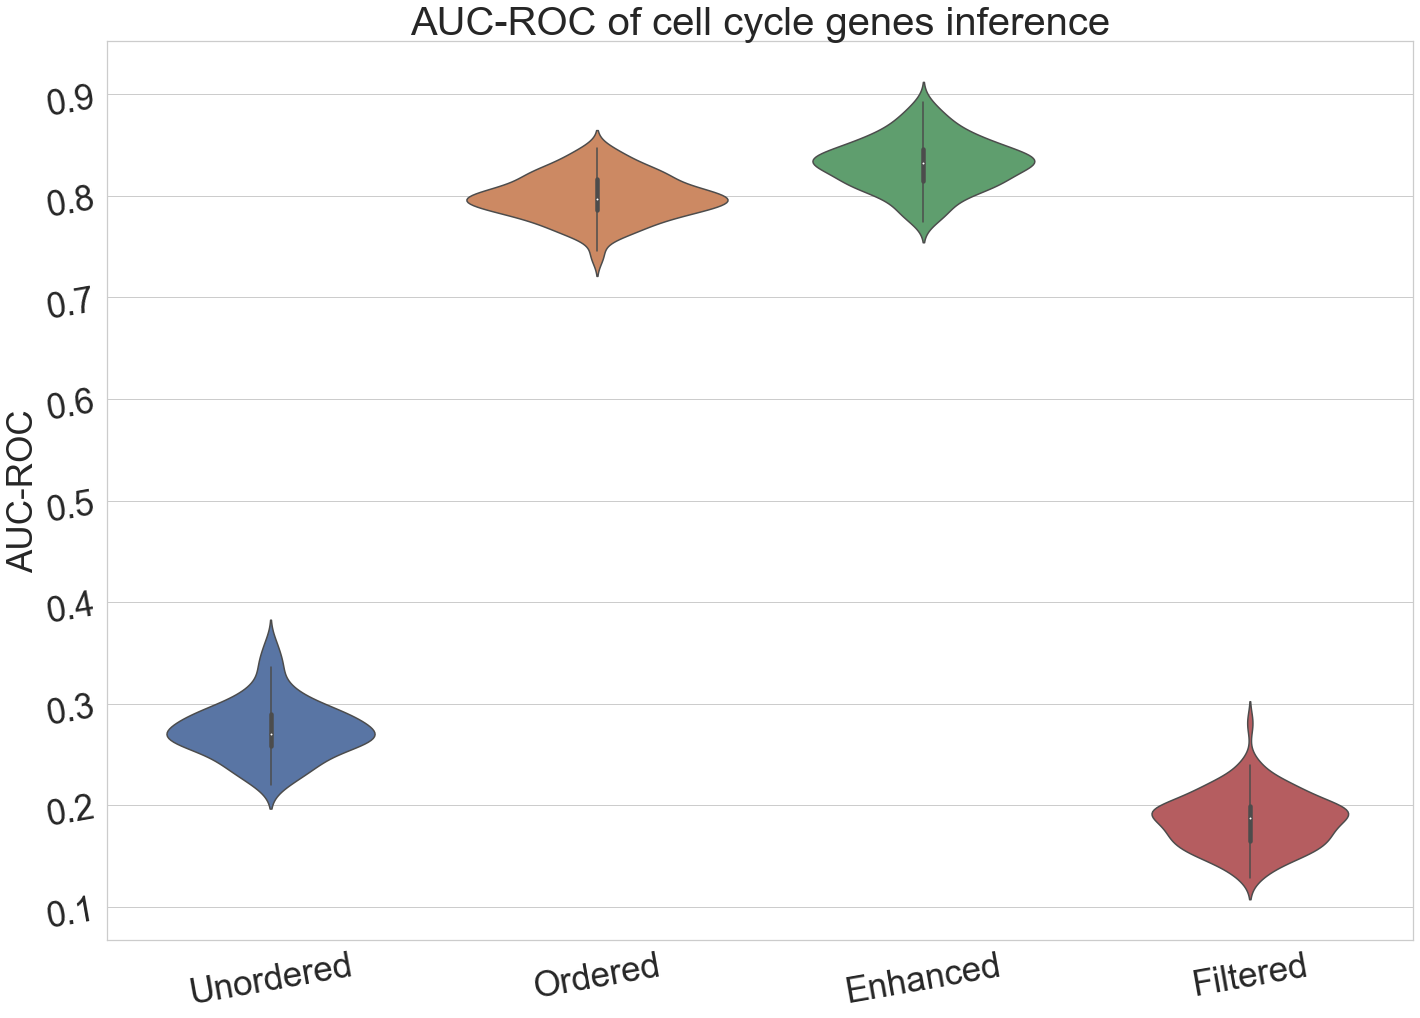

In [12]:
sns.set_style("whitegrid")

b = sns.violinplot(data=data)
#b.axes.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={'figure.figsize':(23.4,16.54)})
b.axes.set_title("AUC-ROC of cell cycle genes inference",fontsize=40)
b.set_ylabel("AUC-ROC",fontsize=35)
b.tick_params(rotation=10,labelsize=35)
#b.axes.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


sns.set(rc={'figure.figsize':(23.4,16.54)})
#plt.title("MSE between simulated cyclic signal and output of enhancement methods" ,fontsize='24')

sns.set_style("whitegrid")

plt.show()